## Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [2]:
AMOUNT_OF_SENSORS = 3
VALIDATION_TESTSET = "004"

## Datapreparation

### Train

In [3]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    knn_train.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
y_train = pd.concat([x.df['Pose'] for x in knn_train])

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Test

In [4]:
knn_test_dict = dict()
y_test_dict = dict()
for key in testing_files:
    knn_test = df_wrapper(testing_files[key].csv_file)
    knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
    knn_test.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = knn_test.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    knn_test_dict[key] = knn_test.df
    y_test_dict[key] = y_test

x_test = knn_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Visualisation

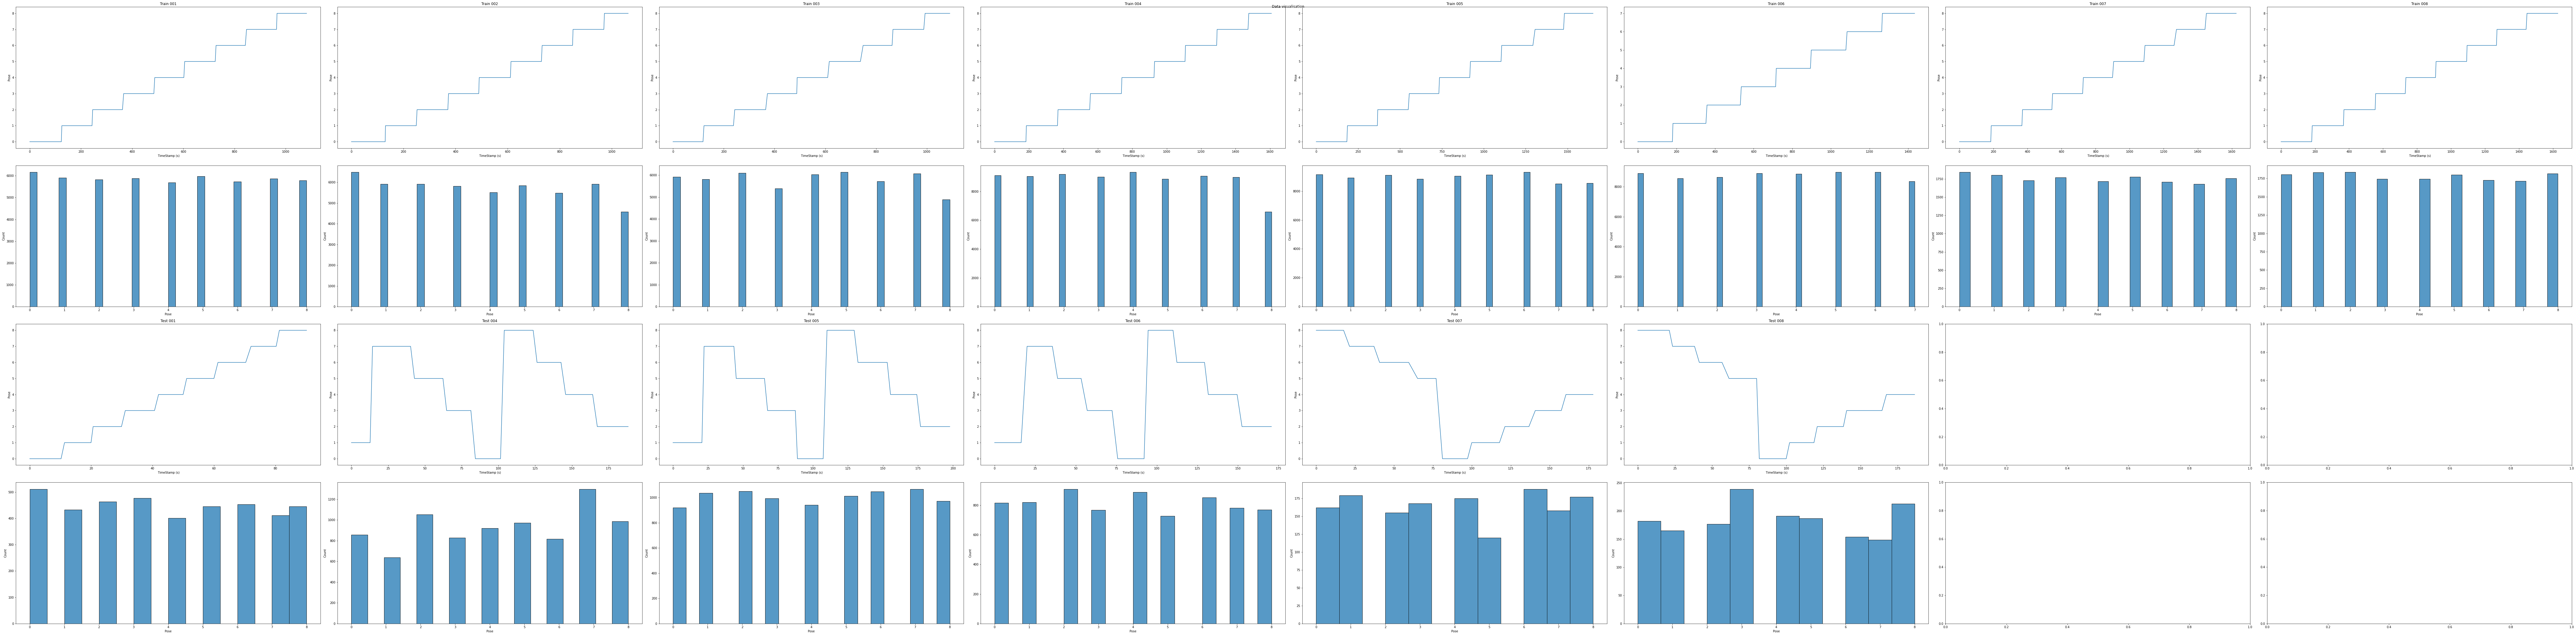

In [5]:
cols = []
height=30
width=(height/2)*len(knn_train)
fig, axes = plt.subplots(4, len(knn_train), figsize=(width, height))
fig.suptitle('Data visualisation')
# Train
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append(f'Train {key}')    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
# Test
cols=[]
for i, key in enumerate(knn_test_dict):
    sns.lineplot(ax=axes[2, i], data=knn_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols.append(f'Test {key}') 
for ax, col in zip(axes[2], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [6]:
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(418127, 39)
(418127,)
(8367, 39)
(8367,)


## Add scaler

In [7]:
#scaler = MinMaxScaler()
#scaler.fit(x_train_numpy)
#x_train_numpy = scaler.transform(x_train_numpy)
#x_test_numpy = scaler.transform(x_test_numpy)

y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

## Hyperparams

In [8]:
EPOCH = 20
BATCH_SIZE = 64
LR = 0.00075
DROPOUT_RATE1 = 0.4
DROPOUT_RATE2 = 0.4
ACTIVATION1 = "relu"
ACTIVATION2 = "softmax"
OPTIM = Adam(learning_rate=LR)
# OPTIM = RMSPROP(learning_rate=LR)

# Shapes
OUTPUT_SHAPE = 9
INPUT_SHAPE = AMOUNT_OF_SENSORS * 13
HIDDEN_SHAPE = int((INPUT_SHAPE + OUTPUT_SHAPE) / 2)


## Model

In [9]:
model = Sequential()
model.add(Dense(INPUT_SHAPE, activation=ACTIVATION1))
#model.add(Dropout(rate=DROPOUT_RATE1))
model.add(Dense(HIDDEN_SHAPE, activation=ACTIVATION1))
model.add(Dropout(rate=DROPOUT_RATE2))
model.add(Dense(OUTPUT_SHAPE, activation=ACTIVATION2))

model.compile(optimizer=OPTIM, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])


## Fit the model

In [10]:
model.fit(x=x_train_numpy, y=y_train, batch_size=BATCH_SIZE, validation_data=(x_test_numpy, y_test), shuffle=True, epochs=EPOCH)


Epoch 1/20
6534/6534 [==============================] - 11s 2ms/step - loss: 2.1398 - accuracy: 0.5910 - val_loss: 1.4425 - val_accuracy: 0.5981
Epoch 2/20
6534/6534 [==============================] - 8s 1ms/step - loss: 0.3048 - accuracy: 0.8832 - val_loss: 1.5691 - val_accuracy: 0.7582
Epoch 3/20
6534/6534 [==============================] - 8s 1ms/step - loss: 0.2201 - accuracy: 0.9280 - val_loss: 1.7962 - val_accuracy: 0.8434
Epoch 4/20
6534/6534 [==============================] - 8s 1ms/step - loss: 0.1927 - accuracy: 0.9371 - val_loss: 2.2409 - val_accuracy: 0.8928
Epoch 5/20
6534/6534 [==============================] - 8s 1ms/step - loss: 0.1834 - accuracy: 0.9399 - val_loss: 2.5205 - val_accuracy: 0.9015
Epoch 6/20
6534/6534 [==============================] - 8s 1ms/step - loss: 0.1658 - accuracy: 0.9471 - val_loss: 1.8610 - val_accuracy: 0.8939
Epoch 7/20
6534/6534 [==============================] - 8s 1ms/step - loss: 0.1529 - accuracy: 0.9517 - val_loss: 2.1473 - val_accuracy

## Visualise the loss

<AxesSubplot:>

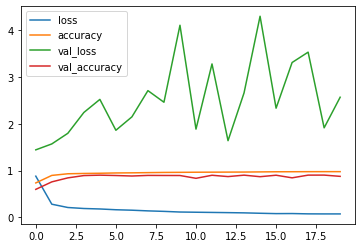

In [11]:
history = pd.DataFrame(model.history.history)
history.plot()

## Predict

In [19]:
print("Classification accuracy:")
classification_dict = dict()

for key in knn_test_dict:
    x_test = knn_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
    classify = model.predict(x_test)
    classifications = [i.argmax() for i in classify]
    annotated_positions = y_test_dict[key].to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    
    print(f"{key}: {round(correct_classifications/len(classifications)*100,2)}%")
    classification_dict[key] = classifications
    
    

Classification accuracy:
001: 77.25%
004: 87.61%
005: 92.69%
006: 71.93%
007: 94.13%
008: 18.29%


## Visualise classification

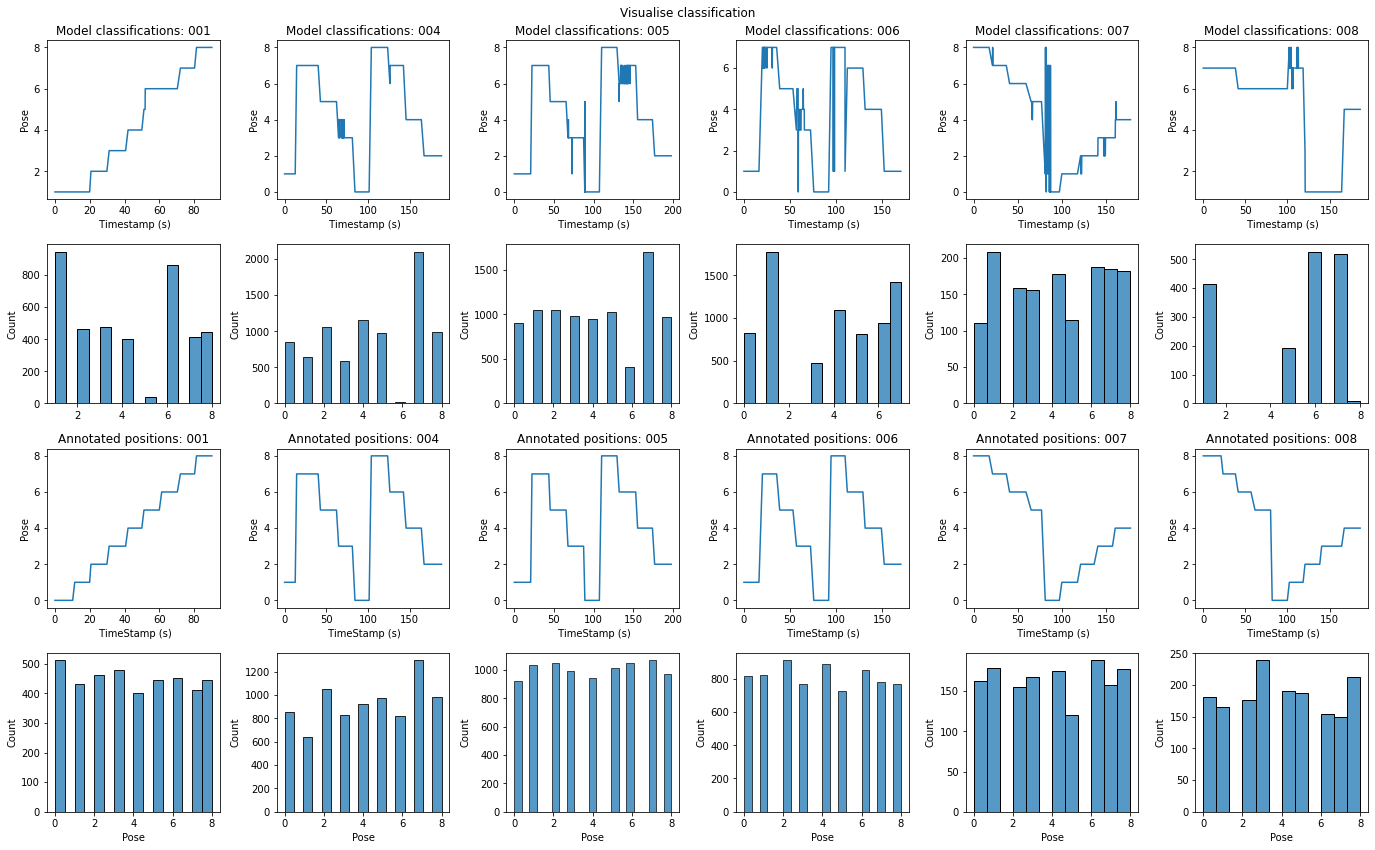

In [13]:
height=12
width=(height/5)*len(knn_train)
cols = [[], []]
fig, axes = plt.subplots(4, len(knn_test_dict), figsize=(width, height))
fig.suptitle('Visualise classification')
for i, key in enumerate(knn_test_dict):
    df_predict = pd.DataFrame({' Timestamp (s)': knn_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[0, i], data=df_predict, x=' Timestamp (s)', y='Pose')
    sns.histplot(ax=axes[1, i], data=classification_dict[key])
    sns.lineplot(ax=axes[2, i], data=knn_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols[0].append(f'Model classifications: {key}')
    cols[1].append(f'Annotated positions: {key}')
for ax, col in zip(axes[0], cols[0]): ax.set_title(col)
for ax, col in zip(axes[2], cols[1]): ax.set_title(col)
fig.tight_layout()
plt.show()

In [14]:
"""
path = f"../models/ANN_model_{AMOUNT_OF_SENSORS}.h5"
model.save(path)
"""

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>